In [ ]:
import os
import cv2
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [ ]:
data_dir = '/content/drive/MyDrive/Data Science/Projects/Covid-19/Train'
test_dir = '/content/drive/MyDrive/Data Science/Projects/Covid-19/Test'
os.listdir(data_dir)

['2', '1', '0', '3']

In [ ]:
image_generator = ImageDataGenerator(rescale= 1./255, validation_split= 0.2)

In [ ]:
train_generator = image_generator.flow_from_directory(batch_size=40, directory=data_dir, shuffle=True, target_size=(256,256), class_mode='categorical', subset='training')
validation_generator = image_generator.flow_from_directory(batch_size=40, directory=data_dir, shuffle=True, target_size=(256,256), class_mode='categorical', subset='validation')
test_generator = image_generator.flow_from_directory(batch_size=40, directory=test_dir, shuffle=True, target_size=(256,256), class_mode='categorical')

Found 428 images belonging to 4 classes.
Found 104 images belonging to 4 classes.
Found 40 images belonging to 4 classes.


In [ ]:
train_images, train_labels = next(train_generator)

In [ ]:
train_images.shape

(40, 256, 256, 3)

In [ ]:
train_labels.shape

(40, 4)

In [ ]:
train_labels

array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.]],

In [ ]:
label_names = {0: 'Covid-19', 1: 'Normal', 2: 'Viral Pneumonia', 3: 'Bacterial Pneumonia'}

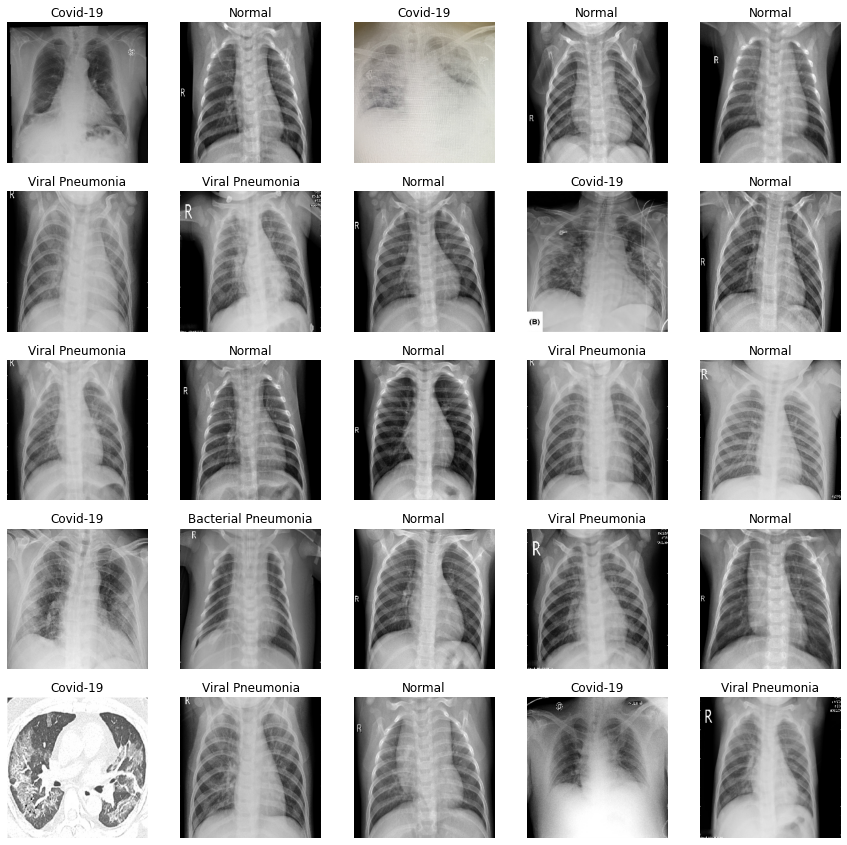

In [ ]:
plt.figure(figsize=(15,15))
for i in range(25):
  plt.subplot(5,5,i+1)
  plt.imshow(train_images[i])
  plt.title(label_names[np.argmax(train_labels[i])])
  plt.axis('off')

# Model

In [ ]:
basemodel = ResNet50(weights='imagenet', include_top=False, input_tensor=Input(shape=(256,256,3)))

for layer in basemodel.layers[:-10]:
  layers.trainable = False

model = basemodel.output
model = AveragePooling2D(pool_size=(4,4))(model)
model = Flatten(name='flatten')(model)
model = Dense(256, activation='relu')(model)
model = Dropout(0.3)(model)
model = Dense(128, activation='relu')(model)
model = Dropout(0.3)(model)
model = Dense(4, activation='softmax')(model)

model = Model(inputs=basemodel.input, outputs=model)

94773248/94765736 [==============================] - 1s 0us/step


In [ ]:
model.compile(loss='categorical_crossentropy', optimizer=optimizers.RMSprop(lr=1e-4, decay=1e-6), metrics=['accuracy'])

earlystopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)
checkpointer = ModelCheckpoint(filepath='weights.hdf5', verbose=1, save_best_only=True)

In [ ]:
train_generator = image_generator.flow_from_directory(batch_size=4, directory=data_dir, shuffle=True, target_size=(256,256), class_mode='categorical', subset='training')
val_generator = image_generator.flow_from_directory(batch_size=4, directory=data_dir, shuffle=True, target_size=(256,256), class_mode='categorical', subset='validation')

Found 428 images belonging to 4 classes.
Found 104 images belonging to 4 classes.


In [ ]:
history = model.fit_generator(train_generator, steps_per_epoch=train_generator.n//4, epochs=25, validation_data=val_generator, validation_steps=val_generator.n//4, callbacks=[checkpointer, earlystopping])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/25
107/107 [==============================] - 164s 1s/step - loss: 1.2240 - accuracy: 0.5331 - val_loss: 3.0920 - val_accuracy: 0.2500

Epoch 00001: val_loss improved from inf to 3.09201, saving model to weights.hdf5
Epoch 2/25
107/107 [==============================] - 13s 120ms/step - loss: 0.4331 - accuracy: 0.8643 - val_loss: 13.1701 - val_accuracy: 0.2500

Epoch 00002: val_loss did not improve from 3.09201
Epoch 3/25
107/107 [==============================] - 13s 121ms/step - loss: 0.2886 - accuracy: 0.9099 - val_loss: 15.0243 - val_accuracy: 0.2500

Epoch 00003: val_loss did not improve from 3.09201
Epoch 4/25
107/107 [==============================] - 13s 122ms/step - loss: 0.2221 - accuracy: 0.9284 - val_loss: 14.2398 - val_accuracy: 0.2500

Epoch 00004: val_loss did not improve from 3.09201
Epoch 5/25
107/107 [==============================] - 13s 124ms/step - loss: 0.1376 - accuracy: 0.9579 - val_loss: 13.0856 - val_accuracy: 0.2308

Epoch 00005: val_loss did not impr

Text(0, 0.5, 'Validation loss')

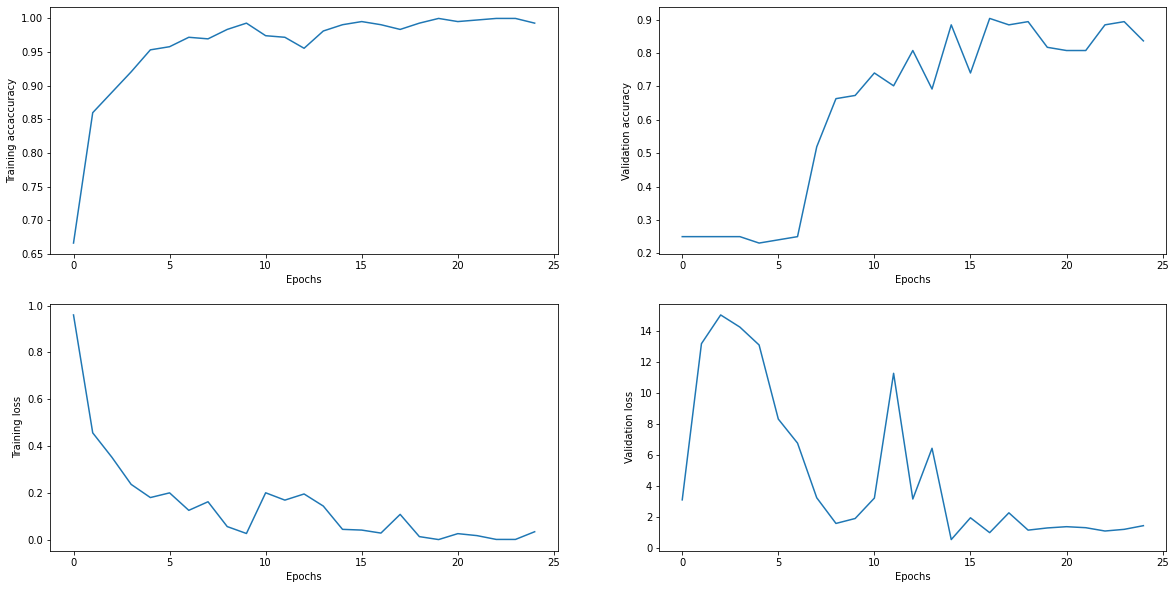

In [ ]:
plt.figure(figsize=(20,10))

plt.subplot(221)
plt.plot(history.history['accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Training accaccuracy')
plt.subplot(222)
plt.plot(history.history['val_accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Validation accuracy')
plt.subplot(223)
plt.plot(history.history['loss'])
plt.xlabel('Epochs')
plt.ylabel('Training loss')
plt.subplot(224)
plt.plot(history.history['val_loss'])
plt.xlabel('Epochs')
plt.ylabel('Validation loss')

In [ ]:
test_images, test_labels = next(test_generator)

In [ ]:
model.evaluate(test_images, test_labels)

2/2 [==============================] - 2s 500ms/step - loss: 5.7409 - accuracy: 0.7750


[5.740935325622559, 0.7749999761581421]